# GLM

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

os.chdir("../../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.experience import charters, tables
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

## Logistic Formula

### Partial Prediction

A logistic regression is of the form:

$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}
$$

The odds ratio determines the increase with a value change in the variable defined as:

$$
odds = \frac{p}{1-p}
$$

If wanting to adjust a value using a base probabilty the probability first needs to be transformed to odds and then adjusted and transformed back

$$
\displaylines{
\text{base\_odds} = \frac{p}{1-p} \\
\text{adj\_odds} = \text{base\_odds} \cdot \text{new\_odds} \\
\text{new\_prob} = \frac{\text{adj\_odds}}{1 + \text{adj\_odds}}
}
$$


Creating a test dataset to show how the parameters of a glm are used.

In [3]:
data = {
    "sex": [0, 0, 0, 1, 1, 1],
    "face": [0, 1, 2, 0, 1, 2],
    "rate": [0.45000, 0.22500, 0.11250, 0.50000, 0.25000, 0.12500],
}
df = pd.DataFrame(data)

preprocess_dict = preprocessors.preprocess_data(
    df,
    feature_dict={
        "target": ["rate"],
        "weight": [],
        "passthrough": ["sex", "face"],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

# model the data
GLM = models.GLM()
GLM.fit(X, y)

 2025-03-03 23:38:27 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-03 23:38:27 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-03 23:38:27 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['face', 'sex', 'constant'] 
 2025-03-03 23:38:27 | morai.forecast.models | INFO     | fiting the model 
 2025-03-03 23:38:27 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001FCCEAB4530> family... 


In [4]:
print(GLM.model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   rate   No. Observations:                    6
Model:                            GLM   Df Residuals:                        3
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2.1671
Date:                Thu, 04 Jul 2024   Deviance:                    0.0032850
Time:                        22:50:32   Pearson chi2:                  0.00328
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1054
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.2078      1.652     -0.126      0.9

In [6]:
odds = GLM.get_odds()
params = GLM.model.params

 2024-07-04 22:50:33 | morai.forecast.models | INFO     | generating odds ratio from model 


The logistic regression can be calculated using the parameters or by using the odds ratios to adjust a partial prediction

In [62]:
# parameters
sex = 0
face = 2

# calculate probability using logistic formula
probability = 1 / (
    1 + np.exp(-(params["constant"] + params["sex"] * sex + params["face"] * face))
)
print(f"probability: {probability}")

# calculate probability from partial prediction
base = 1 / (1 + np.exp(-(params["constant"])))
base_odd = base / (1 - base)
sex_odd = np.exp((params["sex"]) * sex)
face_odd = np.exp((params["face"]) * face)
adj_odd = base_odd * sex_odd * face_odd
new_prob = adj_odd / (1 + adj_odd)
print(f"new_prob: {new_prob}")

probability: 0.10417275399547865
new_prob: 0.10417275399547866


In [70]:
odds["face"]

0.37834865874469387

### Categorization Multiplier

The rate of a multiplier from a logistic regression will be different based on the value of the rate it is applied to. The multiplier will be lower the higher the rate.

In [63]:
t = GLM.generate_table(X, rate_features=["sex"], output_file="simple_glm_mults.xlsx")
t = GLM.generate_table(X, output_file="simple_glm_full.xlsx")

 2024-07-04 23:38:46 | morai.forecast.models | INFO     | generating rate_table with 1 features 
 2024-07-04 23:38:46 | morai.forecast.models | INFO     | generating mult_table for model with 1 features 
 2024-07-04 23:38:46 | morai.forecast.models | WARNING  | the multipliers will not match the predictions from logistic regression especially when base table has high rates. 
 2024-07-04 23:38:46 | morai.forecast.models | INFO     | saving table to C:\Users\johnk\Desktop\github\morai\files\dataset\tables\simple_glm_mults.xlsx 
 2024-07-04 23:38:46 | morai.forecast.models | INFO     | generating rate_table with 2 features 
 2024-07-04 23:38:46 | morai.forecast.models | INFO     | saving table to C:\Users\johnk\Desktop\github\morai\files\dataset\tables\simple_glm_full.xlsx 


In [29]:
rates = X.copy()
rates = tables.map_rates(df=rates, rate="simple_glm_mults")
rates = tables.map_rates(df=rates, rate="simple_glm_full")

 2024-07-04 23:15:12 | morai.experience.tables | INFO     | mapping rate: 'qx_simple_mults' with type: 'workbook' 
 2024-07-04 23:15:12 | morai.experience.tables | WARNING  | rate: 'qx_simple_mults' already exists in the DataFrame. Overwriting the rate. 
 2024-07-04 23:15:12 | morai.experience.tables | INFO     | the mapped rates are based on the following keys: ['sex', 'face'] 
 2024-07-04 23:15:12 | morai.experience.tables | INFO     | mapping rate: 'qx_simple_full' with type: 'workbook' 
 2024-07-04 23:15:12 | morai.experience.tables | INFO     | the mapped rates are based on the following keys: ['sex', 'face'] 


In [51]:
grouped = (
    rates.groupby(["face", "sex"])
    .agg({"qx_simple_mults": "mean", "qx_simple_full": "mean"})
    .unstack()
)
df_ratio = pd.DataFrame(
    {
        "ratio_mult": grouped["qx_simple_mults"][0] / grouped["qx_simple_mults"][1],
        "ratio_full": grouped["qx_simple_full"][0] / grouped["qx_simple_full"][1],
    }
)
df_ratio = df_ratio.reset_index()

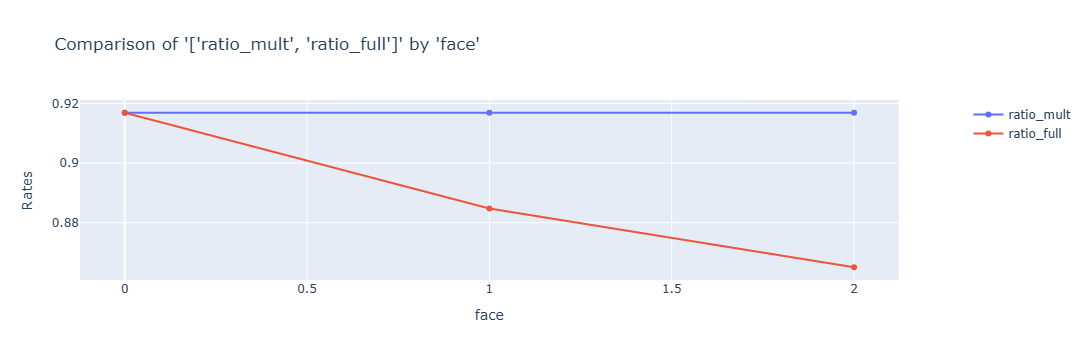

In [52]:
charters.compare_rates(df_ratio, x_axis="face", rates=["ratio_mult", "ratio_full"])

### Omega

In [149]:
colspecs = [(2, 7), (15, 20), (31, 40), (46, 56), (62, 72)]
colnames = ["observation_year", "attained_age", "female", "male", "qx_raw"]
hmd_usa_df = pd.read_fwf(
    "tests/files/forecast/hmd_usa_qx.txt",
    skiprows=3,
    colspecs=colspecs,
    names=colnames,
)
hmd_usa_df = hmd_usa_df[["observation_year", "attained_age", "qx_raw"]]
excluded_ages = [str(age) for age in range(101, 111)] + ["110+"]
hmd_usa_df = hmd_usa_df[~hmd_usa_df["attained_age"].isin(excluded_ages)]
hmd_usa_df["attained_age"] = hmd_usa_df["attained_age"].astype(int)
hmd_usa_df["qx_raw"] = hmd_usa_df["qx_raw"].astype(float)

In [150]:
hmd_usa_df = hmd_usa_df[hmd_usa_df["attained_age"] <= 100]

In [154]:
preprocess_dict = preprocessors.preprocess_data(
    hmd_usa_df,
    feature_dict={
        "target": ["qx_raw"],
        "weight": [],
        "passthrough": ["observation_year", "attained_age"],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

# model the data
GLM = models.GLM()
GLM.fit(X, y)

 2024-09-05 22:52:52 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-09-05 22:52:52 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-09-05 22:52:52 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['observation_year', 'attained_age', 'constant'] 
 2024-09-05 22:52:52 | morai.forecast.models | INFO     | fiting the model 
 2024-09-05 22:52:52 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000002774E4F1940> family... 


In [155]:
mapping = preprocessors.update_mapping(
    mapping=mapping, key="attained_age", values=(0, 200)
)
mapping = preprocessors.update_mapping(
    mapping=mapping, key="observation_year", values={2021: 2021}
)

In [156]:
grid = tables.create_grid(mapping=mapping, max_age=200)

 2024-09-05 22:52:54 | morai.experience.tables | INFO     | Grid size: 201 combinations. 
 2024-09-05 22:52:54 | morai.experience.tables | INFO     | Creating grid with dimensions: ['attained_age', 'constant', 'observation_year'] 


In [157]:
rate, mult = tables.generate_table(
    GLM.model,
    mapping=mapping,
    preprocess_feature_dict=preprocess_dict["feature_dict"],
    preprocess_params=preprocess_dict["params"],
    grid=grid,
)

 2024-09-05 22:52:54 | morai.experience.tables | INFO     | generating table for model GLMResultsWrapper 
 2024-09-05 22:52:54 | morai.experience.tables | INFO     | rate_table shape: (201, 4) 


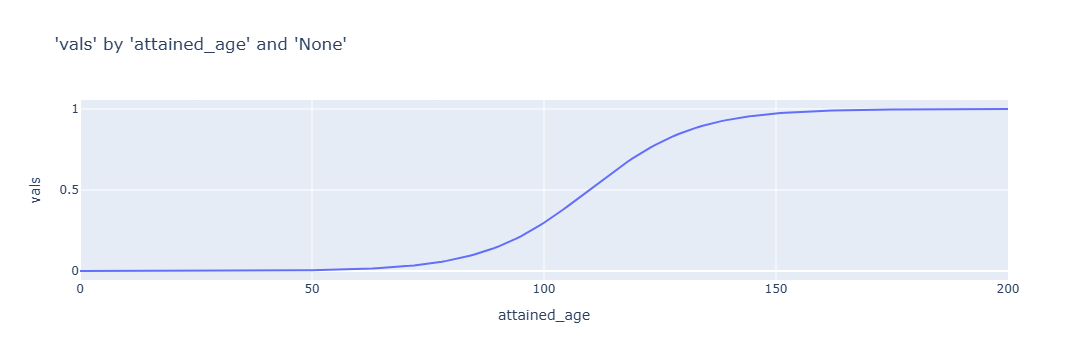

In [158]:
charters.chart(df=rate, x_axis="attained_age", y_axis="vals", type="line")

In [148]:
import importlib

importlib.reload(models)

<module 'morai.forecast.models' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\forecast\\models.py'>

## Separate vs. Interaction Models

This is a simple example to see the impact of creating separate models for each curve or to use interaction variables. In this simple example the `old_rate` are increasing 10% each age while the `new_rate` are increasing 5% each age.

- if you are able to perfectly separate data relationships then the model predictions will be the same. If you aren't able to separate data `interaction` model does not provide the forecast precision as a `separation` model does.
- `cat` model calculates the exact curve

In [32]:
model_data = pd.read_csv("tests/files/forecast/simple_data_diff_curves.csv")
model_data = model_data[["era", "age", "uw", "rate"]]

In [33]:
model_data.head()

,era,age,uw,rate
0,old,10,s,0.10000
1,old,20,s,0.11000
2,old,30,s,0.12100
3,old,40,s,0.13310
4,old,50,s,0.14641


In [34]:
old_data = model_data[model_data["era"] == "old"]
new_data = model_data[model_data["era"] == "new"]

In [35]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict={
        "target": ["rate"],
        "passthrough": ["age"],
        "ohe": [
            "era",
            "uw",
        ],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
X["age_era"] = X["age"] * X["era_old"]
X['era_uw'] = X['era_old'] * X['uw_s']
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

GLM = models.GLM()
GLM.fit(X, y)

predictions = GLM.model.predict(X)
model_data["interaction"] = predictions

 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant'] 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['uw', 'era'] 
 2025-03-04 00:04:41 | morai.forecast.models | INFO     | fiting the model 
 2025-03-04 00:04:41 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001FCF31C41A0> family... 


In [36]:
for dataset, rate in [(old_data, "old"), (new_data, "new")]:
    preprocess_dict = preprocessors.preprocess_data(
        dataset,
        feature_dict={
            "target": ["rate"],
            "passthrough": ["age"],
            "ohe": [
                "uw",
            ],
        },
        standardize=False,
        add_constant=True,
    )

    X = preprocess_dict["X"]
    y = preprocess_dict["y"]
    weights = preprocess_dict["weights"]
    mapping = preprocess_dict["mapping"]

    GLM = models.GLM()
    GLM.fit(X, y)

    predictions = GLM.model.predict(X)
    model_data[rate] = predictions
model_data["separate"] = model_data["new"].combine_first(model_data["old"])
model_data = model_data.drop(columns=["new", "old"])

 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant'] 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['uw'] 
 2025-03-04 00:04:41 | morai.forecast.models | INFO     | fiting the model 
 2025-03-04 00:04:41 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001FCF31C41A0> family... 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 00:04:41 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant

In [37]:
GLM.get_odds()

 2025-03-04 00:04:42 | morai.forecast.models | INFO     | generating odds ratio from model 


age         1.005367
constant    0.028809
uw_s        2.870977
dtype: float64

In [38]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000, learning_rate=0.1, depth=7, cat_features=["uw", "era"]
)
model.fit(model_data[["age", "uw", "era"]], model_data[["rate"]], verbose=0)

In [39]:
predictions = model.predict(model_data[["age", "uw", "era"]])
model_data["cat"] = predictions

In [40]:
model_data["i_div_r"] = model_data["interaction"] / model_data["rate"]
model_data["s_div_r"] = model_data["separate"] / model_data["rate"]
model_data["c_div_r"] = model_data["cat"] / model_data["rate"]

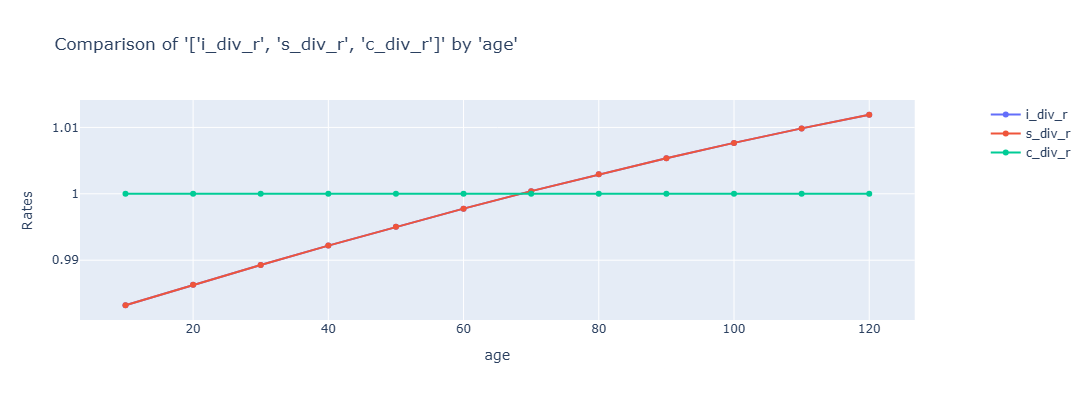

In [41]:
charters.compare_rates(
    model_data[(model_data["era"] == "new") & (model_data["uw"] == "ns")],
    x_axis="age",
    rates=["i_div_r", "s_div_r", "c_div_r"],
)

In [42]:
new = model_data[(model_data["era"] == "new")&(model_data["uw"] == "ns")]
old = model_data[(model_data["era"] == "old")&(model_data["uw"] == "ns")][['era','age','uw','rate']]
merge_new = new.merge(old, how='left', on=['age','uw'], suffixes=['_new','_old'])

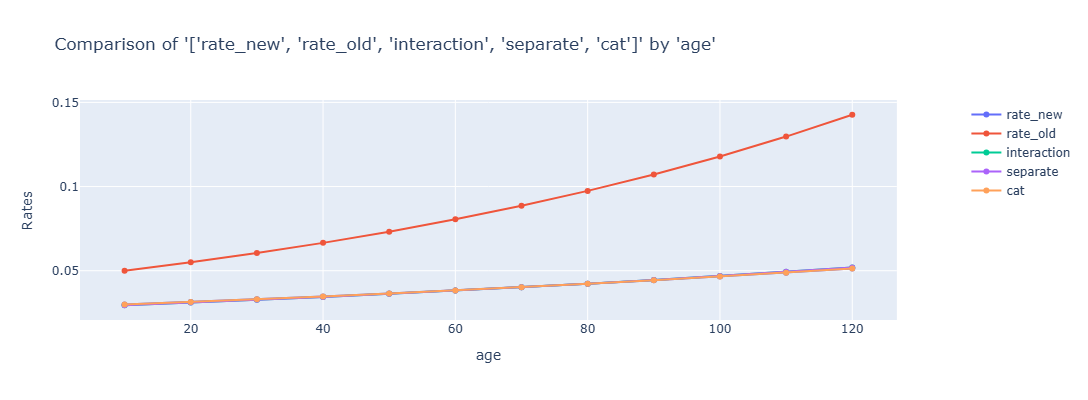

In [43]:
charters.compare_rates(
    merge_new,
    x_axis="age",
    rates=["rate_new", "rate_old", "interaction", "separate", "cat"],
)

### Extrapolating

Extrapolating rates from a model using unknown datapoints can cause incorrect conclusions.

A `interaction` versus a `separate` model will produce the same results so long as the `interaction` perfectly separates the data. 

The model does not produce the curve shape without further manipulation.

In [58]:
model_data = pd.read_csv("tests/files/forecast/simple_data_diff_curve_speed.csv")
model_data = model_data[["speed", "age", "uw", "rate"]]
full_data = model_data.copy()
model_data = model_data[model_data["age"]<=60]

In [62]:
model_data.head()

,speed,age,uw,rate,constant
0,slow,10,s,0.10000,1
1,slow,20,s,0.11000,1
2,slow,30,s,0.12100,1
3,slow,40,s,0.13310,1
4,slow,50,s,0.14641,1


In [63]:
# model data
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict={
        "target": ["rate"],
        "passthrough": ["age"],
        "ohe": [
            "speed",
            "uw",
        ],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
X["age_speed"] = X["age"] * X["speed_slow"]
X['speed_uw'] = X['speed_slow'] * X['uw_s']
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

GLM = models.GLM()
GLM.fit(X, y)

# full data
preprocess_dict = preprocessors.preprocess_data(
    full_data,
    feature_dict={
        "target": ["rate"],
        "passthrough": ["age"],
        "ohe": [
            "speed",
            "uw",
        ],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
X["age_speed"] = X["age"] * X["speed_slow"]
X['speed_uw'] = X['speed_slow'] * X['uw_s']

predictions = GLM.model.predict(X)
full_data["interaction"] = predictions

 2025-03-04 00:27:53 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 00:27:53 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 00:27:53 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant'] 
 2025-03-04 00:27:53 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['uw', 'speed'] 
 2025-03-04 00:27:53 | morai.forecast.models | INFO     | fiting the model 
 2025-03-04 00:27:53 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001FCF908EF60> family... 
 2025-03-04 00:27:53 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 00:27:53 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 00:27:53 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 

In [64]:
for rate in ["slow", "fast"]:
    # model data
    preprocess_dict = preprocessors.preprocess_data(
        model_data[model_data["speed"]==rate],
        feature_dict={
            "target": ["rate"],
            "passthrough": ["age"],
            "ohe": [
                "uw",
            ],
        },
        standardize=False,
        add_constant=True,
    )

    X = preprocess_dict["X"]
    y = preprocess_dict["y"]
    weights = preprocess_dict["weights"]
    mapping = preprocess_dict["mapping"]

    GLM = models.GLM()
    GLM.fit(X, y)

    # full data
    preprocess_dict = preprocessors.preprocess_data(
        full_data[full_data["speed"]==rate],
        feature_dict={
            "target": ["rate"],
            "passthrough": ["age"],
            "ohe": [
                "uw",
            ],
        },
        standardize=False,
        add_constant=True,
    )
    
    X = preprocess_dict["X"]

    predictions = GLM.model.predict(X)
    full_data[rate] = predictions
full_data["separate"] = full_data["fast"].combine_first(full_data["slow"])
full_data = full_data.drop(columns=["fast", "slow"])

 2025-03-04 00:27:59 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 00:27:59 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 00:27:59 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant'] 
 2025-03-04 00:27:59 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['uw'] 
 2025-03-04 00:27:59 | morai.forecast.models | INFO     | fiting the model 
 2025-03-04 00:27:59 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001FCB0263380> family... 
 2025-03-04 00:27:59 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 00:27:59 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 00:27:59 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant

In [65]:
GLM.get_odds()

 2025-03-04 00:28:01 | morai.forecast.models | INFO     | generating odds ratio from model 


age         1.016959
constant    0.024009
uw_s        2.899187
dtype: float64

In [69]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000, learning_rate=0.1, depth=7, cat_features=["uw", "speed"]
)
model.fit(model_data[["age", "uw", "speed"]], model_data[["rate"]], verbose=0)

In [71]:
predictions = model.predict(full_data[["age", "uw", "speed"]])
full_data["cat"] = predictions

In [72]:
fast = full_data[(full_data["speed"] == "fast")&(full_data["uw"] == "s")]
slow = full_data[(full_data["speed"] == "slow")&(full_data["uw"] == "s")][['speed','age','uw','rate']]
merge_fast = fast.merge(slow, how='left', on=['age','uw'], suffixes=['_fast','_slow'])

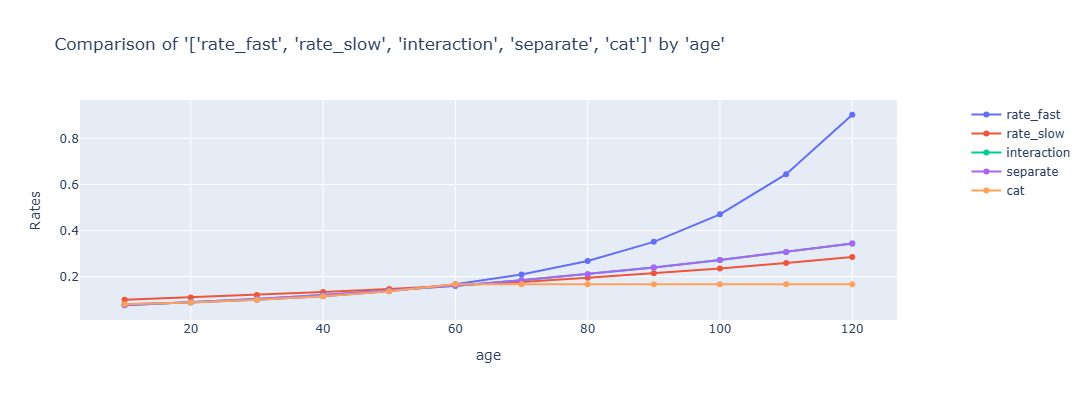

In [73]:
charters.compare_rates(
    merge_fast,
    x_axis="age",
    rates=["rate_fast", "rate_slow", "interaction", "separate", "cat"],
)

### Blending

What happens when data from one model runs out, does it use data from another model or does it remain separate.


In [103]:
model_data = pd.read_csv("tests/files/forecast/simple_data_diff_curves.csv")
model_data = model_data[["era", "age", "uw", "rate"]]
full_data = model_data.copy()
model_data = model_data[((model_data["era"]=="new")&(model_data["age"]<=60))|(model_data["era"]=="old")]

In [104]:
old_data = model_data[model_data["era"] == "old"]
new_data = model_data[model_data["era"] == "new"]

In [105]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict={
        "target": ["rate"],
        "passthrough": ["age"],
        "ohe": [
            "era",
            "uw",
        ],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
# X["age_era"] = X["age"] * X["era_old"]
X['era_uw'] = X['era_old'] * X['uw_s']
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

GLM = models.GLM()
GLM.fit(X, y)

# full data
preprocess_dict = preprocessors.preprocess_data(
    full_data,
    feature_dict={
        "target": ["rate"],
        "passthrough": ["age"],
        "ohe": [
            "era",
            "uw",
        ],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
# X["age_era"] = X["age"] * X["era_old"]
X['era_uw'] = X['era_old'] * X['uw_s']

predictions = GLM.model.predict(X)
full_data["interaction"] = predictions

 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant'] 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['uw', 'era'] 
 2025-03-04 11:10:54 | morai.forecast.models | INFO     | fiting the model 
 2025-03-04 11:10:54 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001FCFE2E1E20> family... 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'c

In [106]:
for rate in ["old", "new"]:
    # model data
    preprocess_dict = preprocessors.preprocess_data(
        model_data[model_data["era"]==rate],
        feature_dict={
            "target": ["rate"],
            "passthrough": ["age"],
            "ohe": [
                "uw",
            ],
        },
        standardize=False,
        add_constant=True,
    )

    X = preprocess_dict["X"]
    y = preprocess_dict["y"]
    weights = preprocess_dict["weights"]
    mapping = preprocess_dict["mapping"]

    GLM = models.GLM()
    GLM.fit(X, y)

    # full data
    preprocess_dict = preprocessors.preprocess_data(
        full_data[full_data["era"]==rate],
        feature_dict={
            "target": ["rate"],
            "passthrough": ["age"],
            "ohe": [
                "uw",
            ],
        },
        standardize=False,
        add_constant=True,
    )
    
    X = preprocess_dict["X"]

    predictions = GLM.model.predict(X)
    full_data[rate] = predictions
full_data["separate"] = full_data["new"].combine_first(full_data["old"])
full_data = full_data.drop(columns=["new", "old"])

 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant'] 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['uw'] 
 2025-03-04 11:10:54 | morai.forecast.models | INFO     | fiting the model 
 2025-03-04 11:10:54 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001FCFE2E1E20> family... 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2025-03-04 11:10:54 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['age', 'constant

In [107]:
new = full_data[(full_data["era"] == "new")&(full_data["uw"] == "s")]
old = full_data[(full_data["era"] == "old")&(full_data["uw"] == "s")][['era','age','uw','rate']]
merge_new = new.merge(old, how='left', on=['age','uw'], suffixes=['_new','_old'])

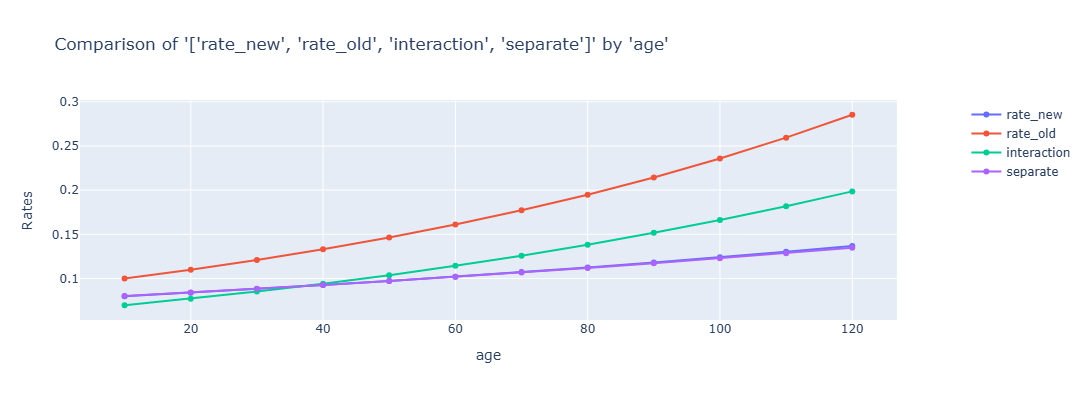

In [108]:
charters.compare_rates(
    merge_new,
    x_axis="age",
    rates=["rate_new", "rate_old", "interaction", "separate"],
)

In [109]:
new = full_data[(full_data["era"] == "new")&(full_data["uw"] == "s")][['era','age','uw','rate']]
old = full_data[(full_data["era"] == "old")&(full_data["uw"] == "s")]
merge_old = old.merge(new, how='left', on=['age','uw'], suffixes=['_old','_new'])

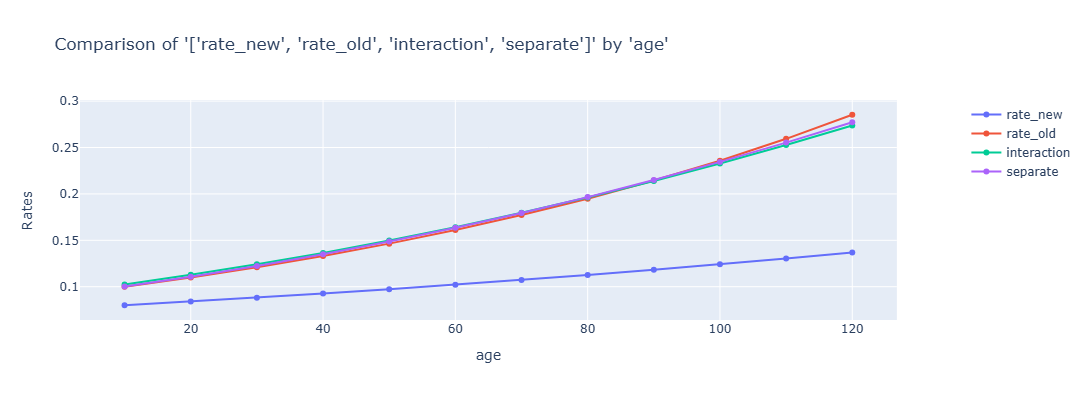

In [110]:
charters.compare_rates(
    merge_old,
    x_axis="age",
    rates=["rate_new", "rate_old", "interaction", "separate"],
)

## Historical Improvement

This is a simple example that is comparing between 2 scenarios.
1. **rate:** historical experience *is not* adjusted for mortality improvment
2. **rate_adj:** historical *is* adjusted for mortality improvement

In [18]:
model_data = pd.read_csv("tests/files/forecast/simple_data.csv")

In [19]:
model_data

,year,gender,rate,rate_adj
0,2010,1,0.10,0.10
1,2011,1,0.09,0.10
2,2012,1,0.08,0.10
3,2013,1,0.07,0.10
4,2014,1,0.06,0.10
5,2015,1,0.05,0.10
6,2016,1,0.04,0.10
7,2017,1,0.03,0.10
8,2018,1,0.02,0.10
9,2019,1,0.01,0.10


In [20]:
forecast_list = [
    {
        "rate": "pred_rate",
        "feature_dict": {
            "target": ["rate"],
            "weight": [],
            "passthrough": ["year", "gender"],
        },
    },
    {
        "rate": "pred_rate_adj",
        "feature_dict": {
            "target": ["rate_adj"],
            "weight": [],
            "passthrough": ["gender"],
        },
    },
    {
        "rate": "pred_rate_gender",
        "feature_dict": {
            "target": ["rate"],
            "weight": [],
            "passthrough": ["gender"],
        },
    },
]

In [21]:
for forecast in forecast_list:
    feature_dict = forecast["feature_dict"]
    rate = forecast["rate"]
    preprocess_dict = preprocessors.preprocess_data(
        model_data, feature_dict=feature_dict, standardize=False, add_constant=True
    )

    X = preprocess_dict["X"]
    y = preprocess_dict["y"]
    weights = preprocess_dict["weights"]
    mapping = preprocess_dict["mapping"]

    GLM = models.GLM()
    GLM.fit(X, y, weights)

    # print(GLM.model.summary())

    predictions = GLM.model.predict(X)
    model_data[rate] = predictions

# charters.pdp(model=GLM.model, df=model_data, x_axis="gender", mapping=mapping)

 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['year', 'gender'] 
 2024-04-19 00:59:52 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:52 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000002433A4869A0> family... 
 2024-04-19 00:59:52 | morai.forecast.models | INFO     | fit the model 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | model target: ['rate_adj'] 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['gender'] 
 2024-04-19 00:59:52 | morai.forecast.models | INFO 

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified



What happens with these predictions is following:
1. **pred_rate:** when predictin on study year and gender and these variables interact, the resulting rates will be a blend and not accurate.
2. **pred_rate_adj:** when predicting on gender after adjusting year rates are perfectly predicted
3. **pred_rate_gender:** when predicting on gender without adjusting year rates it predicts the average mortality (midpoint) and would also be accurate.

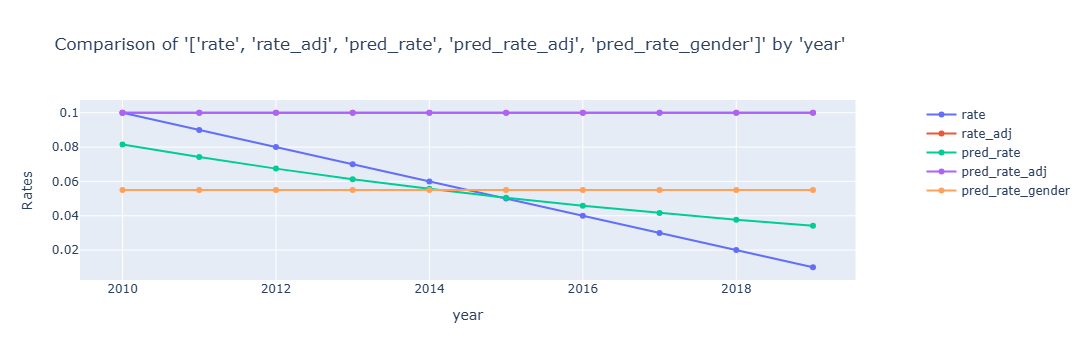

In [22]:
charters.compare_rates(
    model_data[model_data["gender"] == 1],
    x_axis="year",
    rates=["rate", "rate_adj", "pred_rate", "pred_rate_adj", "pred_rate_gender"],
)

## Weighting

This is a simple example compares a GLM when weighting vs. not weighting.
1. **weighting**: this will produce a rate that is close to .9
2. **non-weighted**: this will produce a rate that is the average regardless of weight

In [23]:
model_data = pd.read_csv("tests/files/forecast/simple_data_extreme.csv")

In [24]:
model_data

,record,expose,rate,actual
0,1,1000000,0.9,900000.0
1,1,1,0.1,0.1


In [25]:
X = model_data["record"]
y = model_data["rate"]
success = model_data["actual"]
failure = model_data["expose"] - model_data["actual"]
weights = model_data["expose"]

In [26]:
GLM = models.GLM()
GLM.fit(X, y, weights)
predictions = GLM.model.predict(X)
predictions

 2024-04-19 00:59:57 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000002437F6795B0> family... 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | fit the model 


0    0.899999
1    0.899999
dtype: float64

In [27]:
GLM = models.GLM()
GLM.fit(X, y)
predictions = GLM.model.predict(X)
predictions

 2024-04-19 00:59:57 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000002437CF7E460> family... 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | fit the model 


0    0.5
1    0.5
dtype: float64

In [28]:
GLM = models.GLM()
GLM.fit(X, pd.concat([success, failure], axis=1))
predictions = GLM.model.predict(X)
predictions

 2024-04-19 00:59:58 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:58 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x0000024300032E50> family... 
 2024-04-19 00:59:58 | morai.forecast.models | INFO     | fit the model 


0    0.899999
1    0.899999
dtype: float64

## Credibility

### Importance

A basis of Buhlmann credibility is:
   - large number of observations -> increased credibility
   - mean of the hypothetical variances is small (EPV) -> increased credibility
   - variances of the mean are large (VHM) -> increased credibility

The formula is: $$\frac{N}{N + \left(\frac{\text{EPV}}{\text{VHM}}\right)}$$

Taking this in context of a logistic regression that differs by many features the credibility should be influenced by some features. Here are a few comments on those influences:

   - The most important features will have the largest influence on the rate. For example, for a mortality rate, attained age will have a larger influence than sex.
   - The larger the factor is for the rate the more important the function would be as well.



In [72]:
blend = pd.read_csv("tests/files/experience/blend_credibility.csv")

In [73]:
preprocess_dict = preprocessors.preprocess_data(
    blend,
    feature_dict={
        "target": ["rate"],
        "weight": ["exposure"],
        "passthrough": ["age", "sex", "risk", "sub", "rare"],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

 2024-07-05 00:17:07 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2024-07-05 00:17:07 | morai.forecast.preprocessors | INFO     | model weights: ['exposure'] 
 2024-07-05 00:17:07 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-07-05 00:17:07 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['rare', 'age', 'sub', 'risk', 'sex', 'constant'] 


In [74]:
GLM = models.GLM()
GLM.get_feature_contributions(X, y, weights=weights, base_features=["age"])

 2024-07-05 00:17:08 | morai.forecast.models | INFO     | generating feature contributions from model for 4 features by fitting the model and seeing the reduction in deviance. 
 2024-07-05 00:17:08 | morai.forecast.models | INFO     | base features: '['age', 'constant']' 


,features,contribution,deviance
0,all,1.000000,55.056802
1,base,0.000000,206.645490
2,rare,0.131959,75.060252
3,risk,0.411024,117.363459
4,sex,0.009708,56.528463
5,sub,0.411024,117.363459


In [75]:
GLM.get_odds()

 2024-07-05 00:17:12 | morai.forecast.models | INFO     | generating odds ratio from model 


rare        0.000404
risk        0.794471
sex         0.795323
sub         0.794471
age         1.036657
constant    0.002209
dtype: float64

### SHAP

In [76]:
import shap

shap.initjs()

In [77]:
explainer = shap.Explainer(GLM.model.predict, X)

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning:

overflow encountered in exp

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning:

overflow encountered in exp



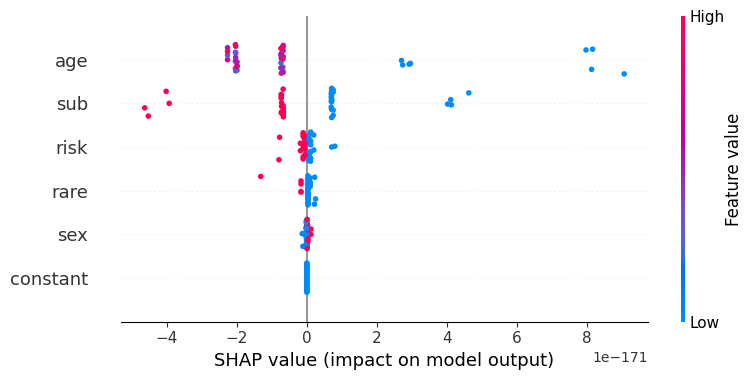

In [78]:
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning:

overflow encountered in exp



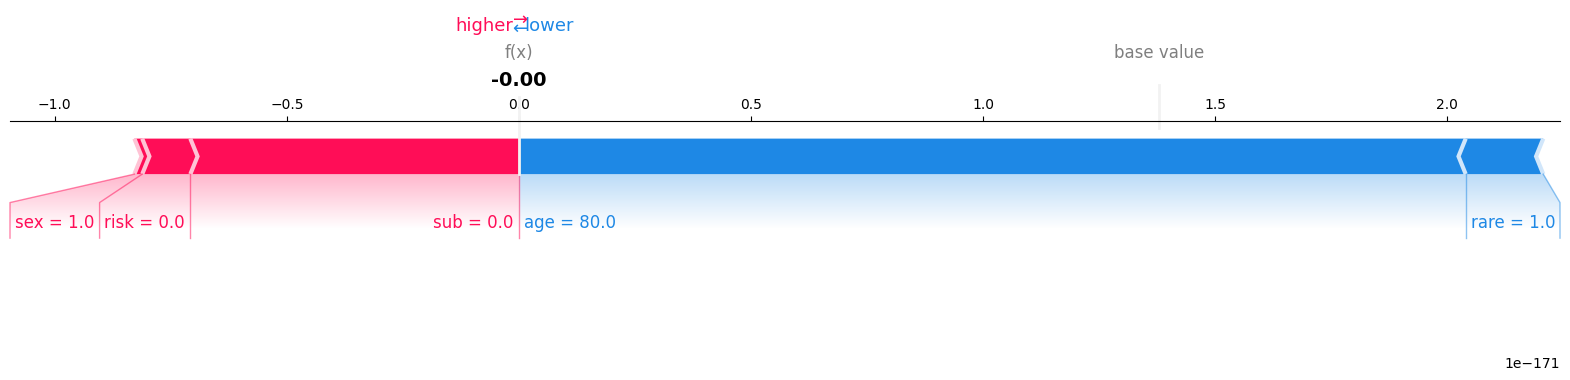

In [79]:
expected_value = np.mean(GLM.model.predict(X))
idx = 8
shap.force_plot(expected_value, shap_values.values[idx], X.iloc[idx], matplotlib=True)

### Grouping

In [10]:
pl_parquet_path = r"files/dataset/mortality_grouped.parquet"

In [11]:
# reading in the dataset
# `enable_string_cache` helps with categorical type values
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
)

In [12]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count:,} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]:,}"
)

row count: 1,793,414 
exposures: 9,873,088,957,759.992


In [13]:
grouped_df = lzdf.collect()

In [14]:
grouped_df = grouped_df.to_pandas()

In [15]:
def get_importance(features, values):
    importance = pd.DataFrame({"feature": features, "importance": values})
    importance = importance.sort_values(by="importance", ascending=False)
    return importance

In [17]:
grouped_df["binned_attained_age"] = preprocessors.bin_feature(
    grouped_df["attained_age"], 22
)
grouped_df["binned_attained_age"] = grouped_df["binned_attained_age"].astype("category")

In [18]:
feature_dict = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "duration"],
    "ordinal": [
        "smoker_status",
        "binned_attained_age",
    ],
    "ohe": [],
    "nominal": [],
}

In [19]:
preprocess_dict = preprocessors.preprocess_data(
    grouped_df,
    feature_dict=feature_dict,
    standardize=False,
    add_constant=True,
)

 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['attained_age', 'duration', 'constant'] 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['binned_attained_age', 'smoker_status'] 


In [20]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

In [21]:
GLM = models.GLM()

In [38]:
GLM.get_feature_contributions(X, y, base_features=[])

 2024-06-30 16:41:55 | morai.forecast.models | INFO     | generating feature contributions from model for 4 features by fitting the model and seeing the reduction in deviance. 
 2024-06-30 16:41:55 | morai.forecast.models | INFO     | base features: '['constant']' 


,features,contribution,deviance
0,all,1.000000,107314.798659
1,base,0.000000,147009.903680
2,attained_age,0.035839,108737.418977
3,binned_attained_age,0.007643,107618.178836
4,duration,0.021797,108180.032182
5,smoker_status,0.028144,108431.977781


In [44]:
GLM.fit(
    X=X[["constant", "duration", "smoker_status", "binned_attained_age"]],
    y=y,
    r_style=False,
)

 2024-06-30 16:45:36 | morai.forecast.models | INFO     | fiting the model 
 2024-06-30 16:45:36 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x0000022F47903AC0> family... 


In [45]:
GLM.model.deviance

108737.41897704714

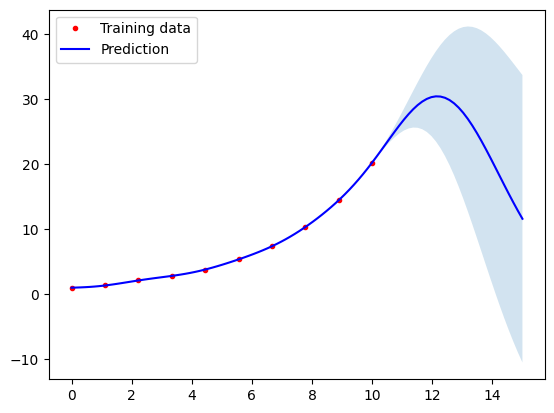

In [74]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Generate exponential data
X = np.linspace(0, 10, 10).reshape(-1, 1)
y = np.exp(0.3 * X).ravel() + np.random.normal(0, 0.1, X.shape[0])

# Define the kernel (RBF = Radial Basis Function)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=2.0, length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, y)

# Predict with uncertainty
X_pred = np.linspace(0, 15, 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_pred, return_std=True)

import matplotlib.pyplot as plt
plt.plot(X, y, 'r.', label="Training data")
plt.plot(X_pred, y_pred, 'b-', label="Prediction")
plt.fill_between(X_pred.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, alpha=0.2)
plt.legend()
plt.show()
